In [76]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py 
py.init_notebook_mode(connected=True)                  
import plotly.graph_objs as go                         
import plotly.tools as tls                             
from collections import Counter                        
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

import warnings
import missingno as msno
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# 1.  Data Acquisition

#### Purpose:
To identify emergency department triage accuracy using the Korean Triage and Acuity Scale (KTAS) and evaluate the causes of mistriage.
#### Variables:
- <b>Group:</b> 
- <b>Sex:</b> Sex of the patient 
- <b>Age:</b> Age of the patient 
- <b>Patients number per hour:</b>
- <b>Arrival mode:</b> Type of transportation to the hospital 
- <b>Injury:</b> Whether the patient is injured or not 
- <b>Chief_complain:</b> The patient's complaint 
- <b>Mental:</b> The mental state of the patient 
- <b>Pain:</b> Whether the patient has pain 
- <b>NRS_pain:</b> Nurse's assessment of pain for the patient 
- <b>SBP:</b> Systolic Blood Pressure.
- <b>DBP:</b> Diastolic Blood Pressure.
- <b>HR:</b> Heat Rate.
- <b>RR:</b> Respiratory rate
- <b>BT:</b> Body Temperature
- <b>Saturation:</b> 
- <b>KTAS_RN:</b>
- <b>Diagnosis in ED:</b>
- <b>Disposition:</b> Action to be taken 
- <b>KTAS_expert:</b>
- <b>Error_group:</b>
- <b>Length of stay_min:</b> 
- <b>KTAS duration_min:</b>
- <b>mistriage:</b>







The technical document in the project of the data set has been reached. It was seen in this document that some numerical data were actually categorical. These values are as follows. 

- Reason Visit : Injury [1 = No, 2= Yes]
- Gender : Sex [1 = Famale, 2 = Male]
- Pain : Pain [1 = Yes, 0 = No]
- Menatal : Mental [1 = Alert, 2 = Verbol Response, 3 = Pain Response, 4 = Unresponse]
- Type of ED : Group [1 = Local ED 3th Degree, 2 = Regional ED 4tg Degree]
- Mode of Arrival : Arrival Mode [1 = Walking, 2 = Public Ambulance, 3 = Private Vehicle, 4 = Private Ambulance, 5,6,7 = Other]
- Disposition : Disposition [1 = Dischange, 2 = Admission to ward, 3 = Admission to ICU, 4 = Disharge, 5 = Transfer, 6 = Death, 7 = Surgery]
- KTAS : KTAS... [1,2,3 = Emergency, 4,5 = Non-Emergency]

## 2. Exploration Data Analysis (EDA)

In [77]:
# Reading the dataset
df = pd.read_csv("data.csv",sep=';',encoding='latin-1')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

In [79]:
# Are there any null values?
df.isnull().values.any()

True

# 3. DATA PREPROCESSING
# 3.1. Missing Value Analysis

In [80]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na

df['NRS_pain'] = df[["NRS_pain"]].replace("#BOÞ!",np.NaN)

missing_values_table(df)

                 n_miss  ratio
Saturation          688 54.300
NRS_pain            556 43.880
Diagnosis in ED       2  0.160


['NRS_pain', 'Saturation', 'Diagnosis in ED']

<AxesSubplot:>

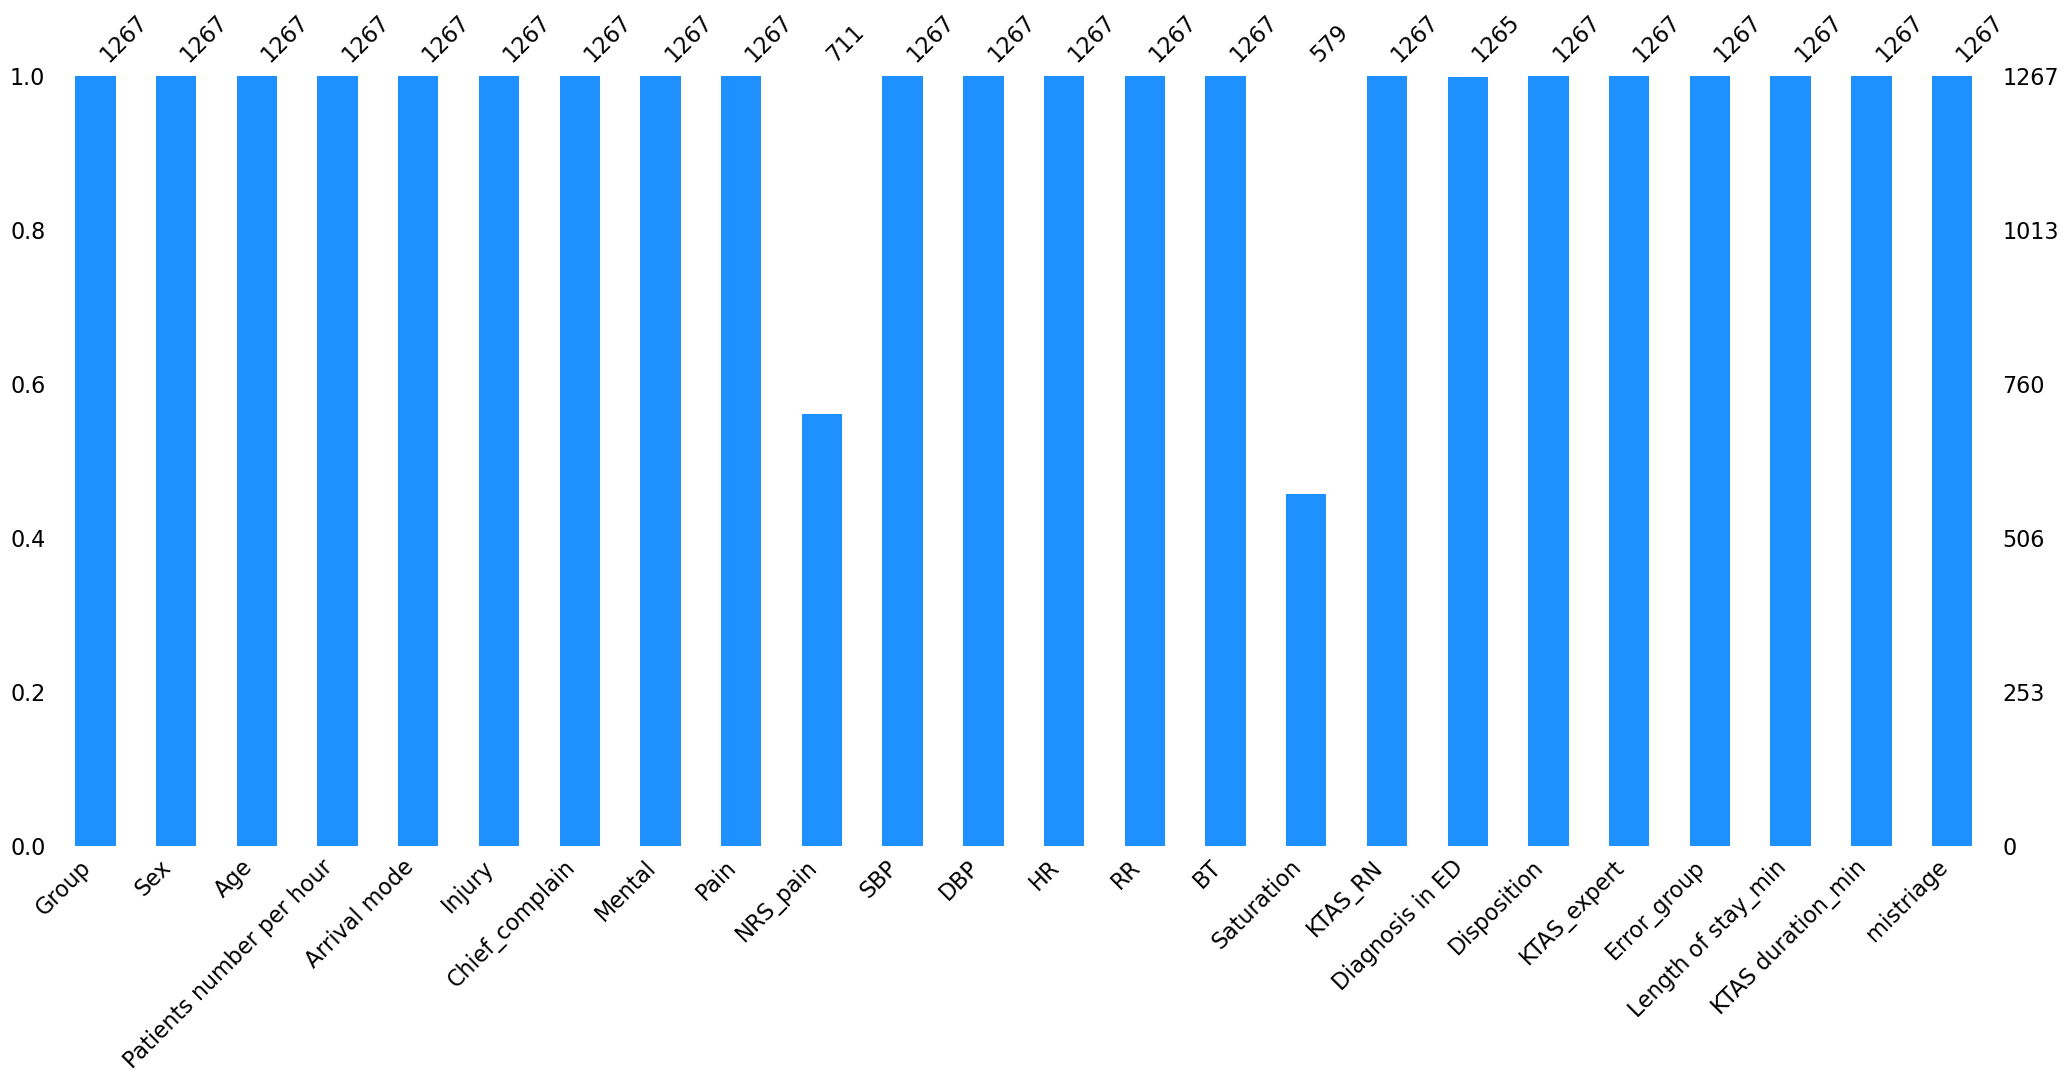

In [81]:
msno.bar(df, color="dodgerblue")

In [82]:
# Fill Missing Value

df["NRS_pain"] = df.groupby(["mistriage", "KTAS_expert"])["NRS_pain"].transform(lambda x: x.fillna(x.mode()[0]))
df["Saturation"] = df.groupby(["mistriage", "KTAS_expert"])["Saturation"].transform(lambda x: x.fillna(x.mode()[0]))
df["Diagnosis in ED"] = df.groupby(["mistriage", "KTAS_expert"])["Diagnosis in ED"].transform(lambda x: x.fillna(x.mode()[0]))

In [83]:
df.isnull().values.any()

False

<AxesSubplot:>

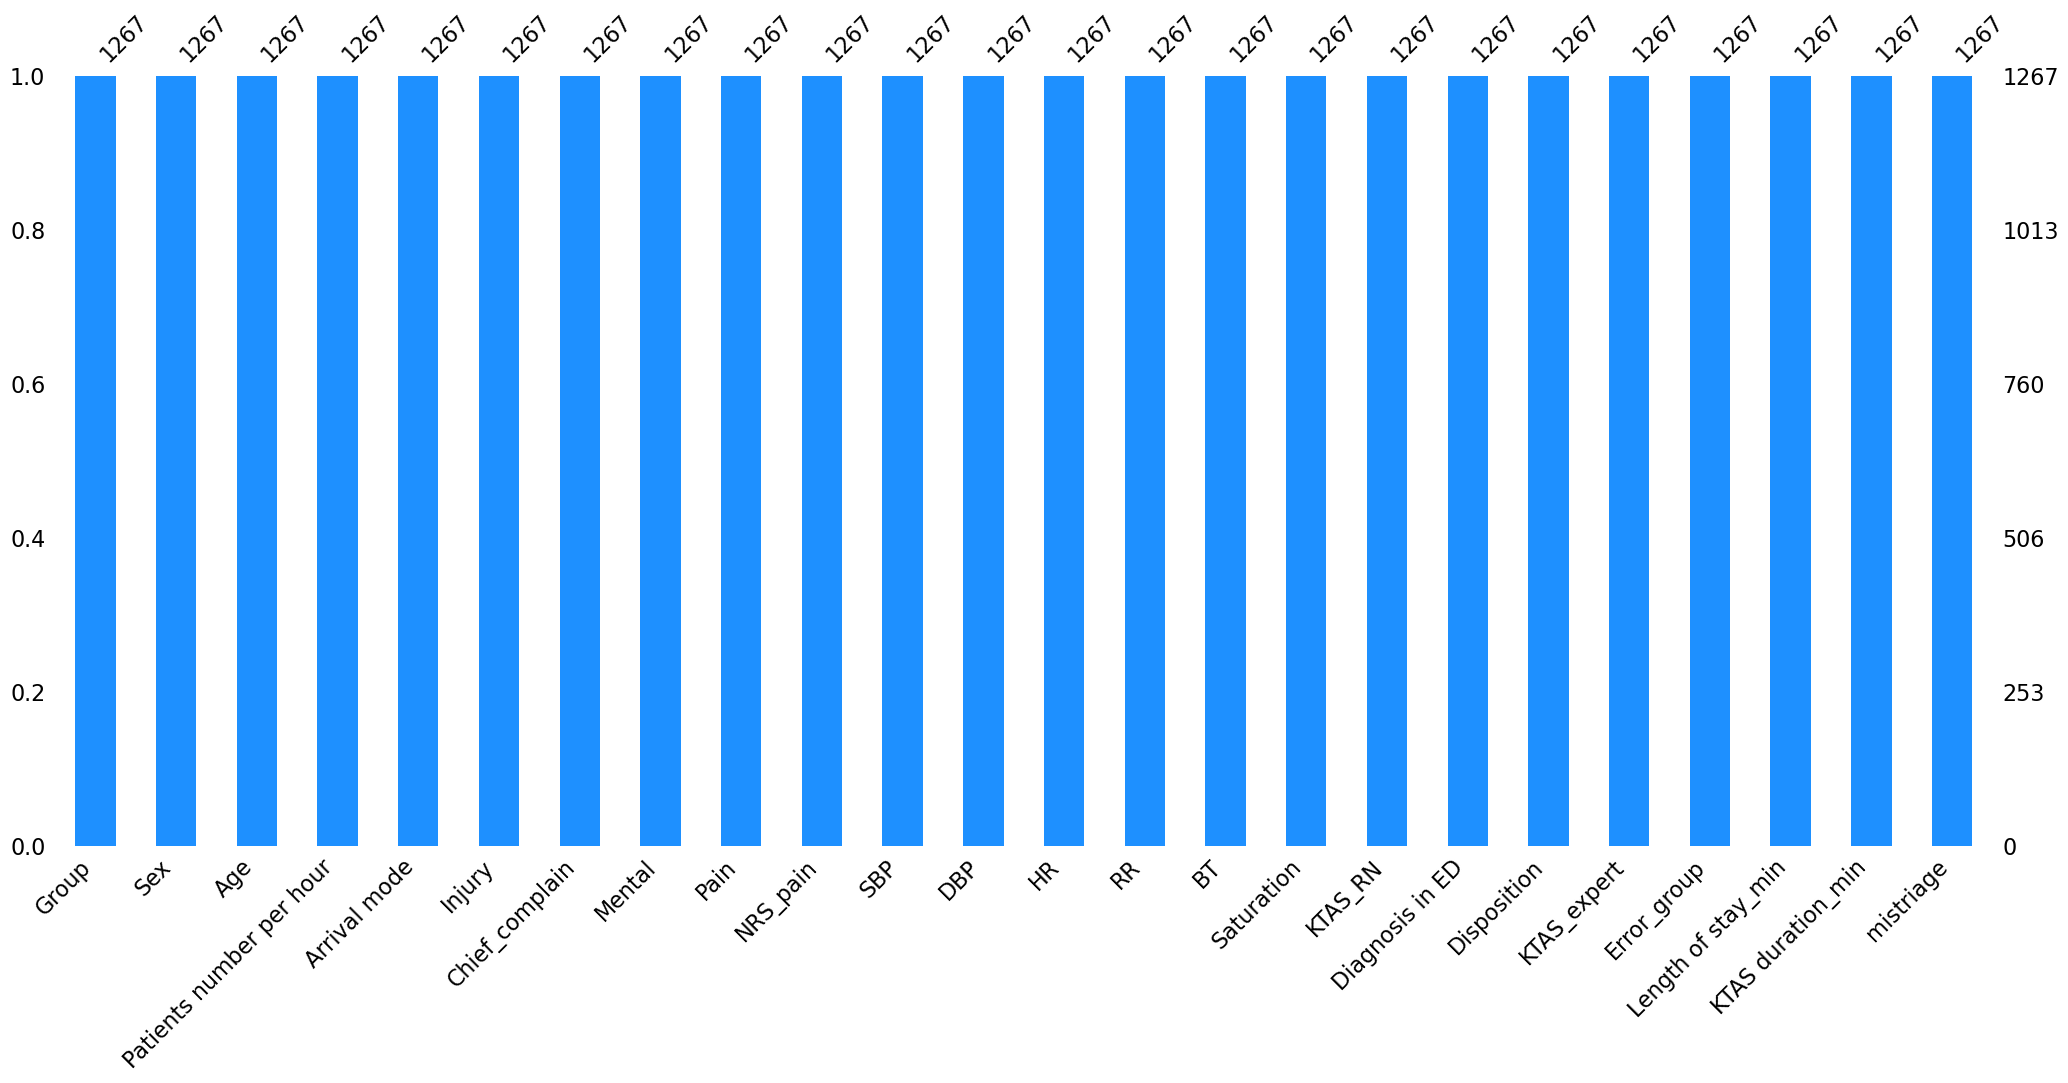

In [84]:
msno.bar(df, color="dodgerblue")

## 3.2. Feature Engineering

In [85]:
df["Saturation"].unique()

array(['100', '98', '97', '95', '99', '96', '78', '68', '88', '89', '92',
       '94', '??', '90', '93', '91', '76', '85', '86', '80', '20', '74'],
      dtype=object)

In [86]:
injury_cat = ['No','Yes']
sex_cat = ['Female','Male']
pain_cat = ['No','Yes']
mental_cat = ['Alert','Verbose Response','Pain Response','Unresponsive']
group_cat = ['Local ED (3th Degree)', 'Regional ED (4th Degree)']
arrival_mode_cat = ['Walking','Public Ambulance', 'Private Vehicle','Private Ambulance', 'Other','Other','Other']
disposition_cat = ['Discharge', 'Admission to Ward', 'Admission to ICU', 'Discharge', 'Transfer', 'Death', 'Surgery']
KTAS_cat = ['Emergency','Emergency','Emergency', 'Non-Emergency', 'Non-Emergency']
mistriage_cat = ['Normal Triage','Over Triage','Under Triage']
error_cat = ['Vital sign','Physical exam','Psychatric','Pain','Mental','Underlying-disease','Medical-records-of-other-ED','On-set','Others']

df['KTAS duration_min'] = df['KTAS duration_min'].apply(lambda x: int(float(x.replace(',', '.'))))
df['NRS_pain'] = df['NRS_pain'].apply(lambda x:int(x))


###############################################################################################################################
#Categorical data were entered as numerical data. Therefore, it was categorized again categorically to make it more meaningful. 
###############################################################################################################################
df.loc[df["Sex"] == 1, "Sex"] = sex_cat[0]
df.loc[df["Sex"] == 2, "Sex"] = sex_cat[1]

df.loc[df["Injury"] == 1, "Injury"] = injury_cat[0]
df.loc[df["Injury"] == 2, "Injury"] = injury_cat[1]

df.loc[df["Pain"] == 0, "Pain"] = pain_cat[0]
df.loc[df["Pain"] == 1, "Pain"] = pain_cat[1]

df.loc[df["Mental"] == 1, "Mental"] = mental_cat[0]
df.loc[df["Mental"] == 2, "Mental"] = mental_cat[1]
df.loc[df["Mental"] == 3, "Mental"] = mental_cat[2]
df.loc[df["Mental"] == 4, "Mental"] = mental_cat[3]

df.loc[df["Group"] == 1, "Group"] = group_cat[0]
df.loc[df["Group"] == 2, "Group"] = group_cat[1]

df.loc[df["Arrival mode"] == 1, "Arrival mode"] = arrival_mode_cat[0]
df.loc[df["Arrival mode"] == 2, "Arrival mode"] = arrival_mode_cat[1]
df.loc[df["Arrival mode"] == 3, "Arrival mode"] = arrival_mode_cat[2]
df.loc[df["Arrival mode"] == 4, "Arrival mode"] = arrival_mode_cat[3]
df.loc[df["Arrival mode"] == 5, "Arrival mode"] = arrival_mode_cat[4]
df.loc[df["Arrival mode"] == 6, "Arrival mode"] = arrival_mode_cat[5]
df.loc[df["Arrival mode"] == 7, "Arrival mode"] = arrival_mode_cat[6]

df.loc[df["Disposition"] == 1, "Disposition"] = disposition_cat[0]
df.loc[df["Disposition"] == 2, "Disposition"] = disposition_cat[1]
df.loc[df["Disposition"] == 3, "Disposition"] = disposition_cat[2]
df.loc[df["Disposition"] == 4, "Disposition"] = disposition_cat[3]
df.loc[df["Disposition"] == 5, "Disposition"] = disposition_cat[4]
df.loc[df["Disposition"] == 6, "Disposition"] = disposition_cat[5]
df.loc[df["Disposition"] == 7, "Disposition"] = disposition_cat[6]

df.loc[df["KTAS_RN"] == 1, "KTAS_RN"] = KTAS_cat[0]
df.loc[df["KTAS_RN"] == 2, "KTAS_RN"] = KTAS_cat[1]
df.loc[df["KTAS_RN"] == 3, "KTAS_RN"] = KTAS_cat[2]
df.loc[df["KTAS_RN"] == 4, "KTAS_RN"] = KTAS_cat[3]
df.loc[df["KTAS_RN"] == 5, "KTAS_RN"] = KTAS_cat[4]

df.loc[df["KTAS_expert"] == 1, "KTAS_expert"] = KTAS_cat[0]
df.loc[df["KTAS_expert"] == 2, "KTAS_expert"] = KTAS_cat[1]
df.loc[df["KTAS_expert"] == 3, "KTAS_expert"] = KTAS_cat[2]
df.loc[df["KTAS_expert"] == 4, "KTAS_expert"] = KTAS_cat[3]
df.loc[df["KTAS_expert"] == 5, "KTAS_expert"] = KTAS_cat[4]

df.loc[df["mistriage"] == 0, "mistriage"] = mistriage_cat[0]
df.loc[df["mistriage"] == 1, "mistriage"] = mistriage_cat[1]
df.loc[df["mistriage"] == 2, "mistriage"] = mistriage_cat[2]

df.loc[df["Error_group"] == 1, "Error_group"] = error_cat[0]
df.loc[df["Error_group"] == 2, "Error_group"] = error_cat[1]
df.loc[df["Error_group"] == 3, "Error_group"] = error_cat[2]
df.loc[df["Error_group"] == 4, "Error_group"] = error_cat[3]
df.loc[df["Error_group"] == 5, "Error_group"] = error_cat[4]
df.loc[df["Error_group"] == 6, "Error_group"] = error_cat[5]
df.loc[df["Error_group"] == 7, "Error_group"] = error_cat[6]
df.loc[df["Error_group"] == 8, "Error_group"] = error_cat[7]
df.loc[df["Error_group"] == 9, "Error_group"] = error_cat[8]
###############################################################################################################################
##############               Nonsense data was encountered in variables containing numerical data.                 ############
##############                 These values have been replaced by the mode of the variable.                        ############
###############################################################################################################################

df[["SBP","DBP","HR","RR","BT","Saturation"]] = df[["SBP","DBP","HR","RR","BT","Saturation"]].replace("??",0).astype(str).astype(float)
df['SBP'] = df['SBP'].replace(0,df['SBP'].mode()[0])
df['DBP'] = df['DBP'].replace(0,df['DBP'].mode()[0])

###############################################################################################################################
##############                                        Feature Engineering                                          ############
###############################################################################################################################
interval = (0, 25, 45, 60, 100)
cats = ['Young', 'Adult', 'Mid_Age', 'Old']
df["New_Age"] = pd.cut(df.Age, interval, labels=cats)

df.loc[df['SBP'] < 80, 'New_SBP'] = 'Low'
df.loc[(df["SBP"] >= 80) & (df["SBP"] <= 120), 'New_SBP'] = 'Normal'
df.loc[df['SBP'] > 120, 'New_SBP'] = 'High'

df.loc[df['DBP'] < 60, 'New_DBP'] = 'Low'
df.loc[(df["DBP"] >= 60) & (df["DBP"] <= 80), 'New_DBP'] = 'Normal'
df.loc[df['DBP'] > 80, 'New_DBP'] = 'High'

df.loc[df['HR'] < 45, 'New_HR'] = 'Low'
df.loc[(df["HR"] >= 45) & (df["HR"] <= 100), 'New_HR'] = 'Normal'
df.loc[df['HR'] > 100, 'New_HR'] = 'High'

df.loc[df['RR'] < 12, 'New_RR'] = 'Low'
df.loc[(df["RR"] >= 12) & (df["RR"] <= 25), 'New_RR'] = 'Normal'
df.loc[df['RR'] > 25, 'New_RR'] = 'High'

df.loc[df['BT'] < 36.4, 'New_BT'] = 'Low'
df.loc[(df["BT"] >= 36.4) & (df["BT"] <= 37.6), 'New_BT'] = 'Normal'
df.loc[df['BT'] > 37.6, 'New_BT'] = 'High'

df.loc[df['Saturation'] < 80, 'New_Saturation'] = 'Extreme'
df.loc[df['Saturation'] > 95 & (df["Saturation"] <= 80 ), 'New_Saturation'] = 'Low'
df.loc[(df["Saturation"] >= 95) & (df["Saturation"] <= 100), 'New_SBP'] = 'Normal'
df.loc[df['Saturation'] > 100, 'New_Saturation'] = 'High'

df.loc[df['NRS_pain'] < 3, 'New_NRS_pain'] = 'Low Pain'
df.loc[(df["NRS_pain"] >= 3) & (df["NRS_pain"] <= 7), 'New_NRS_pain'] = 'Pain'
df.loc[df['NRS_pain'] > 7, 'New_NRS_pain'] = 'High Pain'

df.loc[df['KTAS duration_min'] < 10, 'New_KTAS_duration_min'] = 'Immediate'
df.loc[(df["KTAS duration_min"] >= 10) & (df["KTAS duration_min"] <= 60), 'New_KTAS_duration_min'] = 'Very Urgent'
df.loc[(df["KTAS duration_min"] >= 61) & (df["KTAS duration_min"] <= 120), 'New_KTAS_duration_min'] = 'Urgent'
df.loc[(df["KTAS duration_min"] >= 121) & (df["KTAS duration_min"] <= 240), 'New_KTAS_duration_min'] = 'Standart'
df.loc[df['KTAS duration_min'] > 240, 'New_KTAS_duration_min'] = 'Non-Urgent'

df.loc[df['Length of stay_min'] < 10, 'New_Length_of_stay_min'] = 'Immediate'
df.loc[(df["Length of stay_min"] >= 10) & (df["Length of stay_min"] <= 60), 'New_Length_of_stay_min'] = 'Very Urgent'
df.loc[(df["Length of stay_min"] >= 61) & (df["Length of stay_min"] <= 120), 'New_Length_of_stay_min'] = 'Urgent'
df.loc[(df["Length of stay_min"] >= 121) & (df["Length of stay_min"] <= 240), 'New_Length_of_stay_min'] = 'Standart'
df.loc[df['Length of stay_min'] > 240, 'New_Length_of_stay_min'] = 'Non-Urgent'

df.head()

Group     Sex  Age  Patients number per hour  \
0  Regional ED (4th Degree)    Male   71                         3   
1     Local ED (3th Degree)  Female   56                        12   
2  Regional ED (4th Degree)  Female   68                         8   
3     Local ED (3th Degree)    Male   71                         8   
4     Local ED (3th Degree)    Male   58                         4   

       Arrival mode Injury      Chief_complain Mental Pain  NRS_pain     SBP  \
0   Private Vehicle    Yes   right ocular pain  Alert  Yes         2 160.000   
1   Private Vehicle    Yes  right forearm burn  Alert  Yes         2 137.000   
2  Public Ambulance    Yes        arm pain, Lt  Alert  Yes         2 130.000   
3           Walking     No     ascites tapping  Alert  Yes         3 139.000   
4   Private Vehicle     No     distension, abd  Alert  Yes         3  91.000   

      DBP      HR     RR     BT  Saturation        KTAS_RN  \
0 100.000  84.000 18.000 36.600     100.000      Emergency   
1  75.000  60.000 20.000 36.500      98.000  Non-Emergency   
2  80.000 102.000 20.000 36.600      98.000  Non-Emergency   
3  94.000  88.000 20.000 36.500      98.000  Non-Emergency   
4  67.000  93.000 18.000 36.500      98.000  Non-Emergency   

                                Diagnosis in ED        Disposition  \
0                              Corneal abrasion          Discharge   
1             Burn of hand, firts degree dorsum          Discharge   
2  Fracture of surgical neck of humerus, closed  Admission to Ward   
3        Alcoholic liver cirrhosis with ascites          Discharge   
4                                       Ascites          Discharge   

     KTAS_expert         Error_group  Length of stay_min  KTAS duration_min  \
0  Non-Emergency       Physical exam                  86                  5   
1  Non-Emergency                Pain                  64                  3   
2  Non-Emergency                Pain                 862                  1   
3  Non-Emergency  Underlying-disease                 108                  9   
4  Non-Emergency              On-set                 109                  6   

     mistriage  New_Age New_SBP New_DBP  New_HR  New_RR  New_BT  \
0  Over Triage      Old  Normal    High  Normal  Normal  Normal   
1  Over Triage  Mid_Age  Normal  Normal  Normal  Normal  Normal   
2  Over Triage      Old  Normal  Normal    High  Normal  Normal   
3  Over Triage      Old  Normal    High  Normal  Normal  Normal   
4  Over Triage  Mid_Age  Normal  Normal  Normal  Normal  Normal   

  New_Saturation New_NRS_pain New_KTAS_duration_min New_Length_of_stay_min  
0            Low     Low Pain             Immediate                 Urgent  
1            Low     Low Pain             Immediate                 Urgent  
2            Low     Low Pain             Immediate             Non-Urgent  
3            Low         Pain             Immediate                 Urgent  
4            Low         Pain             Immediate                 Urgent

## 3.3. Outlier Anaysis

In [87]:
##################################################################################################################
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##################################################################################################################
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
##################################################################################################################
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names

In [88]:
has_outliers(df, ["Length of stay_min","Saturation","SBP","DBP","HR","RR","BT"])

Length of stay_min : 19
Saturation : 32
RR : 22
BT : 20


['Length of stay_min', 'Saturation', 'RR', 'BT']

In [89]:
outlier_column = ["Length of stay_min","Saturation","RR","BT"]
for i in outlier_column:
    replace_with_thresholds(df,i)

In [90]:
has_outliers(df, ["SBP","DBP","HR","RR","BT"])

[]

# 5. Data Segmentetion with Machine Learning Models
### 5.1. One Hot Encoding and Robust Scaler

In [91]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=False)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.05)
    quartile3 = variable.quantile(0.95)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

## PREDICT KTAS_EXPERT

In [105]:
new_df = df[["Sex","Injury", "Mental","New_Saturation", "KTAS_expert", "Error_group", "Length of stay_min", "New_Age", "New_SBP", "New_DBP", "New_HR","New_RR", "New_BT", "New_NRS_pain"]]

In [106]:
like_num = [col for col in new_df.columns if new_df[col].dtypes != 'O' and len(new_df[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df.columns if col not in like_num
                   and col not in 'KTAS_expert']

In [107]:
for col in like_num:
    new_df[col] = robust_scaler(new_df[col])

new_df, one_hot_encodeds = one_hot_encoder(new_df, cols_need_scale)

In [108]:
new_df.head()

KTAS_expert  Length of stay_min  Sex_Female  Sex_Male  Injury_No  \
0  Non-Emergency              -0.019           0         1          0   
1  Non-Emergency              -0.021           1         0          0   
2  Non-Emergency               0.058           1         0          0   
3  Non-Emergency              -0.017           0         1          1   
4  Non-Emergency              -0.016           0         1          1   

   Injury_Yes  Mental_Alert  Mental_Pain Response  Mental_Unresponsive  \
0           1             1                     0                    0   
1           1             1                     0                    0   
2           1             1                     0                    0   
3           0             1                     0                    0   
4           0             1                     0                    0   

   Mental_Verbose Response  New_Saturation_Extreme  New_Saturation_Low  \
0                        0                       0                   1   
1                        0                       0                   1   
2                        0                       0                   1   
3                        0                       0                   1   
4                        0                       0                   1   

   Error_group_0  Error_group_Medical-records-of-other-ED  Error_group_Mental  \
0              0                                        0                   0   
1              0                                        0                   0   
2              0                                        0                   0   
3              0                                        0                   0   
4              0                                        0                   0   

   Error_group_On-set  Error_group_Others  Error_group_Pain  \
0                   0                   0                 0   
1                   0                   0                 1   
2                   0                   0                 1   
3                   0                   0                 0   
4                   1                   0                 0   

   Error_group_Physical exam  Error_group_Psychatric  \
0                          1                       0   
1                          0                       0   
2                          0                       0   
3                          0                       0   
4                          0                       0   

   Error_group_Underlying-disease  Error_group_Vital sign  New_Age_Young  \
0                               0                       0              0   
1                               0                       0              0   
2                               0                       0              0   
3                               1                       0              0   
4                               0                       0              0   

   New_Age_Adult  New_Age_Mid_Age  New_Age_Old  New_SBP_High  New_SBP_Low  \
0              0                0            1             0            0   
1              0                1            0             0            0   
2              0                0            1             0            0   
3              0                0            1             0            0   
4              0                1            0             0            0   

   New_SBP_Normal  New_DBP_High  New_DBP_Low  New_DBP_Normal  New_HR_High  \
0               1             1            0               0            0   
1               1             0            0               1            0   
2               1             0            0               1            1   
3               1             1            0               0            0   
4               1             0            0               1            0   

   New_HR_Low  New_HR_Normal  New_RR_High  New_RR_Low  New_RR_Normal  \
0           0     

In [110]:
X = new_df.drop(['KTAS_expert','Sex_Female','Injury_No','Error_group_0','Length of stay_min'],axis=1)
y = np.ravel(new_df[['KTAS_expert']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 357)

In [111]:
X_train.head()

Sex_Male  Injury_Yes  Mental_Alert  Mental_Pain Response  \
428         0           0             1                     0   
772         0           0             1                     0   
873         0           0             1                     0   
572         0           1             1                     0   
385         0           0             1                     0   

     Mental_Unresponsive  Mental_Verbose Response  New_Saturation_Extreme  \
428                    0                        0                       0   
772                    0                        0                       0   
873                    0                        0                       0   
572                    0                        0                       0   
385                    0                        0                       0   

     New_Saturation_Low  Error_group_Medical-records-of-other-ED  \
428                   1                                        0   
772                   1                                        0   
873                   1                                        0   
572                   1                                        0   
385                   1                                        0   

     Error_group_Mental  Error_group_On-set  Error_group_Others  \
428                   0                   0                   0   
772                   0                   0                   0   
873                   0                   0                   0   
572                   0                   0                   0   
385                   0                   0                   0   

     Error_group_Pain  Error_group_Physical exam  Error_group_Psychatric  \
428                 0                          0                       0   
772                 0                          0                       0   
873                 0                          0                       0   
572                 0                          0                       0   
385                 0                          0                       0   

     Error_group_Underlying-disease  Error_group_Vital sign  New_Age_Young  \
428                               0                       0              0   
772                               0                       0              0   
873                               0                       0              0   
572                               0                       0              1   
385                               0                       0              0   

     New_Age_Adult  New_Age_Mid_Age  New_Age_Old  New_SBP_High  New_SBP_Low  \
428              0                0            1             0            0   
772              0                0            1             0            0   
873              1                0            0             0            0   
572              0                0            0             0            0   
385              0                0            1             0            0   

     New_SBP_Normal  New_DBP_High  New_DBP_Low  New_DBP_Normal  New_HR_High  \
428               1             1            0               0            0   
772               1             1            0               0            0   
873               1             0            0               1            0   
572               1             0            0               1            0   
385               1             1            0               0            0   

     New_HR_Low  New_HR_Normal  New_RR_High  New_RR_Low  New_RR_Normal  \
428           0              1            0           0              1   
772           0              1            0           0              1   
873           0              1            0           0              1   
572           0              1            0           0              1   
385           0              1            0           0              1   

     New_BT_High  

In [112]:
# Let's set the parameters to find the best parameter to use in our models. These parameters will be chosen as the best to visit with GridSearchCV.
rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

#xgb_params = {"learning_rate": [0.1, 0.01],
#              "max_depth": [3, 5, 8],
#              "n_estimators": [200, 500, 1000],
#              "colsample_bytree": [0.7, 1]}

rf = RandomForestClassifier(random_state=357)
lgbm = LGBMClassifier(random_state=357)
#xgb = XGBClassifier(random_state=357)

# Let's try the parameters one by one with the help of GridSearchCV and find the best parameter.
gs_cv_rf = GridSearchCV(rf, rf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
#gs_cv_xgb = GridSearchCV(xgb, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [114]:
#lgr_tuned = LogisticRegression(random_state=357).fit(X_train, y_train)
knn_tuned = KNeighborsClassifier().fit(X_train, y_train)
svm_tuned = SVC(random_state=357,gamma='auto').fit(X_train, y_train)
gnb_tuned = GaussianNB().fit(X_train, y_train)
dtc_tuned = DecisionTreeClassifier(random_state=357).fit(X_train, y_train)

# Let's tune the models with the best parameters found.
rf_tuned = RandomForestClassifier(**gs_cv_rf.best_params_, random_state=357).fit(X_train, y_train)
lgbm_tuned = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train, y_train)
#xgb_tuned = XGBClassifier(**gs_cv_xgb.best_params_, random_state=357).fit(X_train, y_train)

In [115]:
# Result
models = [#("LGR", lgr_tuned),
          ("KNN", knn_tuned),
          ("SVM", svm_tuned),
          ("GNB", gnb_tuned),
          ("DTC", dtc_tuned),
          ("RF", rf_tuned),
          ("LGBM", lgbm_tuned),
          #("XGB", xgb_tuned)
         ]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

KNN: (0.566929)
SVM: (0.649606)
GNB: (0.500000)
DTC: (0.610236)
RF: (0.653543)
LGBM: (0.661417)


In [116]:
X_test.head()

Sex_Male  Injury_Yes  Mental_Alert  Mental_Pain Response  \
752         0           1             1                     0   
965         1           0             1                     0   
678         1           1             1                     0   
870         1           0             1                     0   
954         1           1             1                     0   

     Mental_Unresponsive  Mental_Verbose Response  New_Saturation_Extreme  \
752                    0                        0                       0   
965                    0                        0                       0   
678                    0                        0                       0   
870                    0                        0                       0   
954                    0                        0                       0   

     New_Saturation_Low  Error_group_Medical-records-of-other-ED  \
752                   1                                        0   
965                   1                                        0   
678                   1                                        0   
870                   1                                        0   
954                   1                                        0   

     Error_group_Mental  Error_group_On-set  Error_group_Others  \
752                   0                   0                   0   
965                   0                   0                   0   
678                   0                   0                   0   
870                   0                   0                   0   
954                   0                   0                   0   

     Error_group_Pain  Error_group_Physical exam  Error_group_Psychatric  \
752                 0                          0                       0   
965                 0                          0                       0   
678                 0                          0                       0   
870                 0                          0                       0   
954                 0                          0                       0   

     Error_group_Underlying-disease  Error_group_Vital sign  New_Age_Young  \
752                               0                       0              0   
965                               0                       0              0   
678                               0                       0              0   
870                               0                       0              0   
954                               0                       0              0   

     New_Age_Adult  New_Age_Mid_Age  New_Age_Old  New_SBP_High  New_SBP_Low  \
752              0                0            1             0            0   
965              0                1            0             0            0   
678              1                0            0             0            0   
870              1                0            0             0            0   
954              0                1            0             0            0   

     New_SBP_Normal  New_DBP_High  New_DBP_Low  New_DBP_Normal  New_HR_High  \
752               1             0            0               1            0   
965               1             1            0               0            0   
678               1             0            0               1            0   
870               1             0            0               1            0   
954               1             1            0               0            1   

     New_HR_Low  New_HR_Normal  New_RR_High  New_RR_Low  New_RR_Normal  \
752           0              1            0           0              1   
965           0              1            0           0              1   
678           0              1            0           0              1   
870           0              1            0           0              1   
954           0              0            0           0              1   

     New_BT_High  

In [59]:
np.where(X.columns=='Injury_Yes')[0][0]

2

In [94]:
def predict_KTAS_expert(Saturation,Sexm,Injuryy,Mental,Painy,KTAS_RN,Error_group,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain):
    Mental_index = np.where(X.columns==Mental)[0][0]
    KTAS_RN_index = np.where(X.columns==KTAS_RN)[0][0]
    Error_group_index = np.where(X.columns==Error_group)[0][0]
    New_Age_index = np.where(X.columns==New_Age)[0][0]
    New_SBP_index = np.where(X.columns==New_SBP)[0][0]
    New_DBP_index = np.where(X.columns==New_DBP)[0][0]
    New_HR_index = np.where(X.columns==New_HR)[0][0]
    New_RR_index = np.where(X.columns==New_RR)[0][0]
    New_BT_index = np.where(X.columns==New_BT)[0][0]
    New_NRS_pain_index = np.where(X.columns==New_NRS_pain)[0][0]
  
    x = np.zeros(len(X.columns))
    x[0] = Saturation
    x[1] = Sexm
    x[2] = Injuryy
    x[7] = Painy
    
    if Mental_index >= 0:
        x[Mental_index] = 1
    if KTAS_RN_index >= 0:
        x[KTAS_RN_index] = 1
    if Error_group_index >= 0:
        x[Error_group_index] = 1
    if New_Age_index >= 0:
        x[New_Age_index] = 1
    if New_SBP_index >= 0:
        x[New_SBP_index] = 1
    if New_DBP_index >= 0:
        x[New_DBP_index] = 1
    if New_HR_index >= 0:
        x[New_HR_index] = 1
    if New_RR_index >= 0:
        x[New_RR_index] = 1
    if New_BT_index >= 0:
        x[New_BT_index] = 1
    if New_NRS_pain_index >= 0:
        x[New_NRS_pain_index] = 1

    return rf_tuned.predict([x])[0]

In [101]:
predict_KTAS_expert(0.400,1,0,'Mental_Pain Response',1,'KTAS_RN_Non-Emergency','Error_group_Others','New_Age_Young','New_SBP_Normal','New_DBP_Normal','New_HR_Normal','New_RR_Normal','New_BT_Normal','New_NRS_pain_Low Pain')

'Non-Emergency'

In [102]:
X.columns

Index(['Saturation', 'Sex_Male', 'Injury_Yes', 'Mental_Alert',
       'Mental_Pain Response', 'Mental_Unresponsive',
       'Mental_Verbose Response', 'Pain_Yes', 'KTAS_RN_Emergency',
       'KTAS_RN_Non-Emergency', 'Error_group_Medical-records-of-other-ED',
       'Error_group_Mental', 'Error_group_On-set', 'Error_group_Others',
       'Error_group_Pain', 'Error_group_Physical exam',
       'Error_group_Psychatric', 'Error_group_Underlying-disease',
       'Error_group_Vital sign', 'New_Age_Young', 'New_Age_Adult',
       'New_Age_Mid_Age', 'New_Age_Old', 'New_SBP_High', 'New_SBP_Low',
       'New_SBP_Normal', 'New_DBP_High', 'New_DBP_Low', 'New_DBP_Normal',
       'New_HR_High', 'New_HR_Low', 'New_HR_Normal', 'New_RR_High',
       'New_RR_Low', 'New_RR_Normal', 'New_BT_High', 'New_BT_Low',
       'New_BT_Normal', 'New_NRS_pain_High Pain', 'New_NRS_pain_Low Pain',
       'New_NRS_pain_Pain'],
      dtype='object')

In [124]:
import pickle
with open('triage-application_model.pickle','wb') as f:
    pickle.dump(rf_tuned,f)

In [125]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

## PREDICT DISPOSITION

In [105]:
new_df1 = df[["Sex","Injury", "Mental", "Pain", "Saturation", "KTAS_RN","Disposition", "KTAS_expert","Error_group", "Length of stay_min","New_Age", "New_SBP", "New_DBP", "New_HR","New_RR", "New_BT", "New_NRS_pain"]]

In [106]:
like_num = [col for col in new_df1.columns if new_df1[col].dtypes != 'O' and len(new_df1[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df1.columns if col not in like_num
                   and col not in 'Disposition']

In [107]:
for col in like_num:
    new_df1[col] = robust_scaler(new_df1[col])

new_df1, one_hot_encodeds = one_hot_encoder(new_df1, cols_need_scale)

In [108]:
X1 = new_df1.drop(['Disposition','Sex_Female','Injury_No','Pain_No','Error_group_0','Length of stay_min'],axis=1)
y1 = np.ravel(new_df1[['Disposition']])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state = 357)

In [109]:
X_train1.head()

Saturation  Sex_Male  Injury_Yes  Mental_Alert  Mental_Pain Response  \
428      -0.600         0           0             1                     0   
772       0.000         0           0             1                     0   
873       0.000         0           0             1                     0   
572       0.000         0           1             1                     0   
385      -0.400         0           0             1                     0   

     Mental_Unresponsive  Mental_Verbose Response  Pain_Yes  \
428                    0                        0         1   
772                    0                        0         0   
873                    0                        0         0   
572                    0                        0         1   
385                    0                        0         1   

     KTAS_RN_Emergency  KTAS_RN_Non-Emergency  KTAS_expert_Emergency  \
428                  1                      0                      1   
772                  1                      0                      1   
873                  1                      0                      1   
572                  1                      0                      1   
385                  0                      1                      0   

     KTAS_expert_Non-Emergency  Error_group_Medical-records-of-other-ED  \
428                          0                                        0   
772                          0                                        0   
873                          0                                        0   
572                          0                                        0   
385                          1                                        0   

     Error_group_Mental  Error_group_On-set  Error_group_Others  \
428                   0                   0                   0   
772                   0                   0                   0   
873                   0                   0                   0   
572                   0                   0                   0   
385                   0                   0                   0   

     Error_group_Pain  Error_group_Physical exam  Error_group_Psychatric  \
428                 0                          0                       0   
772                 0                          0                       0   
873                 0                          0                       0   
572                 0                          0                       0   
385                 0                          0                       0   

     Error_group_Underlying-disease  Error_group_Vital sign  New_Age_Young  \
428                               0                       0              0   
772                               0                       0              0   
873                               0                       0              0   
572                               0                       0              1   
385                               0                       0              0   

     New_Age_Adult  New_Age_Mid_Age  New_Age_Old  New_SBP_High  New_SBP_Low  \
428              0                0            1             1            0   
772              0                0            1             1            0   
873              1                0            0             1            0   
572              0                0            0             0            0   
385              0                0            1             1            0   

     New_SBP_Normal  New_DBP_High  New_DBP_Low  New_DBP_Normal  New_HR_High  \
428               0             1            0               0            0   
772               0             1            0               0            0   
873               0             0            0               1            0   
572               1             0            0               1            0   
385               0             1            0               0            0   



In [136]:
# Let's set the parameters to find the best parameter to use in our models. These parameters will be chosen as the best to visit with GridSearchCV.
rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

#xgb_params = {"learning_rate": [0.1, 0.01],
#              "max_depth": [3, 5, 8],
#              "n_estimators": [200, 500, 1000],
#              "colsample_bytree": [0.7, 1]}

rf = RandomForestClassifier(random_state=357)
lgbm = LGBMClassifier(random_state=357)
#xgb = XGBClassifier(random_state=357)

# Let's try the parameters one by one with the help of GridSearchCV and find the best parameter.
gs_cv_rf = GridSearchCV(rf, rf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train1, y_train1)
gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train1, y_train1)
#gs_cv_xgb = GridSearchCV(xgb, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [137]:
#lgr_tuned = LogisticRegression(random_state=357).fit(X_train, y_train)
knn_tuned1 = KNeighborsClassifier().fit(X_train1, y_train1)
svm_tuned1 = SVC(random_state=357,gamma='auto').fit(X_train1, y_train1)
gnb_tuned1 = GaussianNB().fit(X_train1, y_train1)
dtc_tuned1 = DecisionTreeClassifier(random_state=357).fit(X_train1, y_train1)

# Let's tune the models with the best parameters found.
rf_tuned1 = RandomForestClassifier(**gs_cv_rf.best_params_, random_state=357).fit(X_train1, y_train1)
lgbm_tuned1 = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train1, y_train1)
#xgb_tuned = XGBClassifier(**gs_cv_xgb.best_params_, random_state=357).fit(X_train, y_train)

In [138]:
# Result
models1 = [#("LGR", lgr_tuned),
          ("KNN", knn_tuned1),
          ("SVM", svm_tuned1),
          ("GNB", gnb_tuned1),
          ("DTC", dtc_tuned1),
          ("RF", rf_tuned1),
          ("LGBM", lgbm_tuned1),
          #("XGB", xgb_tuned)
         ]

for name, model in models1:
    y_pred1 = model.predict(X_test1)
    acc = accuracy_score(y_test1, y_pred1)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

KNN: (0.669291)
SVM: (0.704724)
GNB: (0.062992)
DTC: (0.590551)
RF: (0.732283)
LGBM: (0.736220)


In [139]:
def predict_KTAS_expert1(Saturation,Sexm,Injuryy,Mental,Painy,KTAS_RN,KTAS_expert,Error_group,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain):
    Mental_index = np.where(X1.columns==Mental)[0][0]
    KTAS_RN_index = np.where(X1.columns==KTAS_RN)[0][0]
    KTAS_expert_index = np.where(X1.columns==KTAS_expert)[0][0]
    Error_group_index = np.where(X1.columns==Error_group)[0][0]
    New_Age_index = np.where(X1.columns==New_Age)[0][0]
    New_SBP_index = np.where(X1.columns==New_SBP)[0][0]
    New_DBP_index = np.where(X1.columns==New_DBP)[0][0]
    New_HR_index = np.where(X1.columns==New_HR)[0][0]
    New_RR_index = np.where(X1.columns==New_RR)[0][0]
    New_BT_index = np.where(X1.columns==New_BT)[0][0]
    New_NRS_pain_index = np.where(X1.columns==New_NRS_pain)[0][0]
  
    x = np.zeros(len(X1.columns))
    x[0] = Saturation
    x[1] = Sexm
    x[2] = Injuryy
    x[7] = Painy
    
    if Mental_index >= 0:
        x[Mental_index] = 1
    if KTAS_RN_index >= 0:
        x[KTAS_RN_index] = 1
    if KTAS_expert_index >= 0:
        x[KTAS_expert_index] = 1
    if Error_group_index >= 0:
        x[Error_group_index] = 1
    if New_Age_index >= 0:
        x[New_Age_index] = 1
    if New_SBP_index >= 0:
        x[New_SBP_index] = 1
    if New_DBP_index >= 0:
        x[New_DBP_index] = 1
    if New_HR_index >= 0:
        x[New_HR_index] = 1
    if New_RR_index >= 0:
        x[New_RR_index] = 1
    if New_BT_index >= 0:
        x[New_BT_index] = 1
    if New_NRS_pain_index >= 0:
        x[New_NRS_pain_index] = 1

    return rf_tuned1.predict([x])[0]

In [140]:
predict_KTAS_expert1(0.400,1,1,'Mental_Alert',1,'KTAS_RN_Emergency','KTAS_expert_Emergency','Error_group_Physical exam','New_Age_Old','New_SBP_High','New_DBP_High','New_HR_High','New_RR_Normal','New_BT_High','New_NRS_pain_Pain')

'Admission to Ward'

In [141]:
import pickle
with open('triage-application_model1.pickle','wb') as f:
    pickle.dump(rf_tuned1,f)

In [142]:
    
import json
columns = {
    'data_columns' : [col.lower() for col in X1.columns]
}
with open("columns1.json","w") as f:
    f.write(json.dumps(columns))

## PREDICT Length of stay min

In [179]:
new_df2 = df[["Sex","Injury", "Mental", "Pain", "Saturation", "KTAS_RN","KTAS_expert","Disposition", "Error_group", "Length of stay_min","New_Age", "New_SBP", "New_DBP", "New_HR","New_RR", "New_BT", "New_NRS_pain"]]

In [180]:
like_num = [col for col in new_df2.columns if new_df2[col].dtypes != 'O' and len(new_df2[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df2.columns if col not in like_num
                   and col not in 'Length of stay_min']

In [181]:
for col in like_num:
    new_df2[col] = robust_scaler(new_df2[col])

new_df2, one_hot_encodeds = one_hot_encoder(new_df2, cols_need_scale)

In [182]:
X2 = new_df2.drop(['Sex_Female','Injury_No','Pain_No','Error_group_0','Length of stay_min'],axis=1)
y2 = np.ravel(new_df2[['Length of stay_min']])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state = 357)

In [183]:
y_train2

array([ 0.966,  0.006, -0.02 , ..., -0.017,  0.05 ,  1.039])

In [184]:
# Let's set the parameters to find the best parameter to use in our models. These parameters will be chosen as the best to visit with GridSearchCV.
rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

#xgb_params = {"learning_rate": [0.1, 0.01],
#              "max_depth": [3, 5, 8],
#              "n_estimators": [200, 500, 1000],
#              "colsample_bytree": [0.7, 1]}

rf = RandomForestClassifier(random_state=357)
lgbm = LGBMClassifier(random_state=357)
#xgb = XGBClassifier(random_state=357)

# Let's try the parameters one by one with the help of GridSearchCV and find the best parameter.
gs_cv_rf = GridSearchCV(rf, rf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train2, y_train2)
gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train2, y_train2)
#gs_cv_xgb = GridSearchCV(xgb, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


ValueError: Unknown label type: 'continuous'

In [ ]:
#lgr_tuned = LogisticRegression(random_state=357).fit(X_train, y_train)
knn_tuned2 = KNeighborsClassifier().fit(X_train2, y_train2)
svm_tuned2 = SVC(random_state=357,gamma='auto').fit(X_train2, y_train2)
gnb_tuned2 = GaussianNB().fit(X_train2, y_train2)
dtc_tuned2 = DecisionTreeClassifier(random_state=357).fit(X_train2, y_train2)

# Let's tune the models with the best parameters found.
rf_tuned2 = RandomForestClassifier(**gs_cv_rf.best_params_, random_state=357).fit(X_train2, y_train2)
lgbm_tuned2 = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train2, y_train2)
#xgb_tuned = XGBClassifier(**gs_cv_xgb.best_params_, random_state=357).fit(X_train, y_train)

In [ ]:
# Result
models2 = [#("LGR", lgr_tuned),
          ("KNN", knn_tuned2),
          ("SVM", svm_tuned2),
          ("GNB", gnb_tuned2),
          ("DTC", dtc_tuned2),
          ("RF", rf_tuned2),
          ("LGBM", lgbm_tuned2),
          #("XGB", xgb_tuned)
         ]

for name, model in models2:
    y_pred1 = model.predict(X_test2)
    acc = accuracy_score(y_test2, y_pred2)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

In [ ]:
def predict_KTAS_expert2(Saturation,Sexm,Injuryy,Mental,Painy,KTAS_RN,KTAS_expert,Error_group,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain):
    Mental_index = np.where(X2.columns==Mental)[0][0]
    KTAS_RN_index = np.where(X2.columns==KTAS_RN)[0][0]
    KTAS_expert_index = np.where(X2.columns==KTAS_expert)[0][0]
    Error_group_index = np.where(X2.columns==Error_group)[0][0]
    New_Age_index = np.where(X2.columns==New_Age)[0][0]
    New_SBP_index = np.where(X2.columns==New_SBP)[0][0]
    New_DBP_index = np.where(X2.columns==New_DBP)[0][0]
    New_HR_index = np.where(X2.columns==New_HR)[0][0]
    New_RR_index = np.where(X2.columns==New_RR)[0][0]
    New_BT_index = np.where(X2.columns==New_BT)[0][0]
    New_NRS_pain_index = np.where(X2.columns==New_NRS_pain)[0][0]
  
    x = np.zeros(len(X2.columns))
    x[0] = Saturation
    x[1] = Sexm
    x[2] = Injuryy
    x[7] = Painy
    
    if Mental_index >= 0:
        x[Mental_index] = 1
    if KTAS_RN_index >= 0:
        x[KTAS_RN_index] = 1
    if KTAS_expert_index >= 0:
        x[KTAS_expert_index] = 1
    if Error_group_index >= 0:
        x[Error_group_index] = 1
    if New_Age_index >= 0:
        x[New_Age_index] = 1
    if New_SBP_index >= 0:
        x[New_SBP_index] = 1
    if New_DBP_index >= 0:
        x[New_DBP_index] = 1
    if New_HR_index >= 0:
        x[New_HR_index] = 1
    if New_RR_index >= 0:
        x[New_RR_index] = 1
    if New_BT_index >= 0:
        x[New_BT_index] = 1
    if New_NRS_pain_index >= 0:
        x[New_NRS_pain_index] = 1

    return rf_tuned2.predict([x])[0]